### Preparing to prediction (including FE)

In [1]:

import pandas as pd
import numpy as np 
traindf = pd.read_csv(r"C:\Users\Dell\Documents\Data Science, Machine Learning\Datasets\train.csv").set_index('PassengerId')
testdf = pd.read_csv(r"C:\Users\Dell\Documents\Data Science, Machine Learning\Datasets\test.csv").set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0)
train_y = df.Survived.loc[traindf.index]
df2 = pd.concat([df.WomanOrBoySurvived.fillna(0), df.Alone, df.Sex.replace({'female': 0, 'male': 1})], axis=1)
test_x = df2.loc[testdf.index]

# The one line of the code for prediction : LB = 0.83253 (Titanic Top 3%) 
y_pred_top3 = (((test_x.WomanOrBoySurvived <= 0.238) & (test_x.Sex < 0.5) & (test_x.Alone > 0.5)) | \
          ((test_x.WomanOrBoySurvived > 0.238) & \
           ~((test_x.WomanOrBoySurvived > 0.55) & (test_x.WomanOrBoySurvived <= 0.633)))).astype(int)

# Saving the result
pd.DataFrame({'Survived': y_pred_top3}, \
             index=testdf.index).reset_index().to_csv('survived_top3.csv', index=False)
print('Mean =', y_pred_top3.mean(), ' Std =', y_pred_top3.std())

Mean = 0.3349282296650718  Std = 0.47253093702252047


In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
from scipy.spatial.distance import cosine

import time
import graphviz
import matplotlib.pyplot as plt
print(__doc__)

import warnings
warnings.filterwarnings("ignore")


np.random.seed(0)

Automatically created module for IPython interactive environment


In [3]:
# FE
#Title
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

In [4]:
# Embarked
df['Embarked'] = df['Embarked'].fillna('S')

In [5]:
# Fare
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare) 

In [6]:
# Cabin, Deck
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

In [7]:
#Age
df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

In [8]:
# Family_Size
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
pd.set_option('max_columns',100)

In [9]:
pd.set_option('max_columns',100)
traindf.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [10]:
df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [11]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,Braund,0.0,0.0,0.0,True,M,2
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,Cumings,0.0,0.0,0.0,True,C,2
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,Heikkinen,0.0,0.0,0.0,True,M,1


In [12]:
train_y = df.Survived.loc[traindf.index]

In [13]:
cols_to_drop = ['Name','Ticket','Cabin','Survived']
df = df.drop(cols_to_drop, axis=1)

In [14]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

In [15]:
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [16]:
train_x_all, test_x_all = df.loc[traindf.index], df.loc[testdf.index]
train_x_all.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,10,0,100,0.0,0.0,0.0,1,7,2
2,1,0,38.0,1,0,71.2833,0,11,1,182,0.0,0.0,0.0,1,2,2
3,3,0,26.0,0,0,7.9250,2,9,1,329,0.0,0.0,0.0,1,7,1


### Clustering

In [17]:
# The minimal percentage of similarity of the clustered feature with "Survived" for inclusion in the final dataset
limit_opt = 0.7

In [18]:
n_clusters_opt = 3 # number of clusters
# Thanks to: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
default_base = {'quantile': .2,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': n_clusters_opt,
                'min_samples': 3,
                'xi': 0.05,
                'min_cluster_size': 0.05}

In [19]:
train_x_all.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
       'IsWomanOrBoy', 'LastName', 'WomanOrBoyCount', 'FamilySurvivedCount',
       'WomanOrBoySurvived', 'Alone', 'Deck', 'Family_Size'],
      dtype='object')

In [20]:
# Features list for clustering
feature_first = 'WomanOrBoySurvived'
clustered_features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'WomanOrBoyCount', 'Alone', 'Deck', 'Family_Size']

In [21]:
def generate_data(x1,x2,df,t):
    # x1, x2 as string - name of features from dataframe df
    # t=1 - with train_y, t=0 - without its
    X = pd.concat([df[x1], df[x2]], axis=1).values
    if t==1:
        y = train_y.values.astype(int)
        return (X, y)
    else:
        return X

In [22]:
title_plot = {}
i = -1
for features in clustered_features:
    i += 1
    if (features != 'WomanOrBoyCount') and (features != 'Family_Size'):
        title_plot[i] = 'W-' + features
    elif (features == 'WomanOrBoyCount'):
        title_plot[i] = 'W-W|B-Count'
    elif (features == 'Family_Size'):
        title_plot[i] = 'W-FamSize'
    
title_plot

{0: 'W-Pclass',
 1: 'W-Sex',
 2: 'W-Age',
 3: 'W-Fare',
 4: 'W-Embarked',
 5: 'W-Title',
 6: 'W-W|B-Count',
 7: 'W-Alone',
 8: 'W-Deck',
 9: 'W-FamSize'}

In [23]:
# train dataset
datasets = []
for i in range(len(clustered_features)):
    datasets.append((generate_data(feature_first,clustered_features[i],train_x_all,1),{}))

In [24]:
# test dataset
datasets_test = []
rez = pd.DataFrame(index = test_x.index)
for i in range(len(clustered_features)):
    datasets_test.append(generate_data(feature_first,clustered_features[i],test_x_all,0))

In [25]:
def generate_clustering_algorithms(Z,n_clusters):
    # generate clustering algorithms
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(df, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        Z, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state = 1000)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'])
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('KMeans', kmeans),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )
    return clustering_algorithms

0 0 0.349 W-Pclass MiniBatchKMeans
0 1 0.349 W-Pclass KMeans
0 2 0.58 W-Pclass AffinityPropagation
0 3 nan W-Pclass MeanShift
0 4 0.693 W-Pclass SpectralClustering
0 5 0.606 W-Pclass Ward
0 6 0.27 W-Pclass AgglomerativeClustering
0 7 0.657 W-Pclass DBSCAN
0 8 0.525 W-Pclass OPTICS
0 9 0.445 W-Pclass Birch
0 10 0.604 W-Pclass GaussianMixture
Optimal ==>  SpectralClustering
1 0 0.473 W-Sex MiniBatchKMeans
1 1 0.549 W-Sex KMeans
1 2 0.495 W-Sex AffinityPropagation
1 3 nan W-Sex MeanShift
1 4 0.411 W-Sex SpectralClustering
1 5 0.213 W-Sex Ward
1 6 0.706 W-Sex AgglomerativeClustering
1 7 0.785 W-Sex DBSCAN
1 8 0.584 W-Sex OPTICS
1 9 0.55 W-Sex Birch
1 10 0.876 W-Sex GaussianMixture
Optimal ==>  GaussianMixture
2 0 0.449 W-Age MiniBatchKMeans
2 1 0.385 W-Age KMeans
2 2 0.582 W-Age AffinityPropagation
2 3 nan W-Age MeanShift
2 4 0.149 W-Age SpectralClustering
2 5 0.446 W-Age Ward
2 6 0.118 W-Age AgglomerativeClustering
2 7 0.515 W-Age DBSCAN
2 8 0.117 W-Age OPTICS
2 9 0.321 W-Age Birch
2 10 0

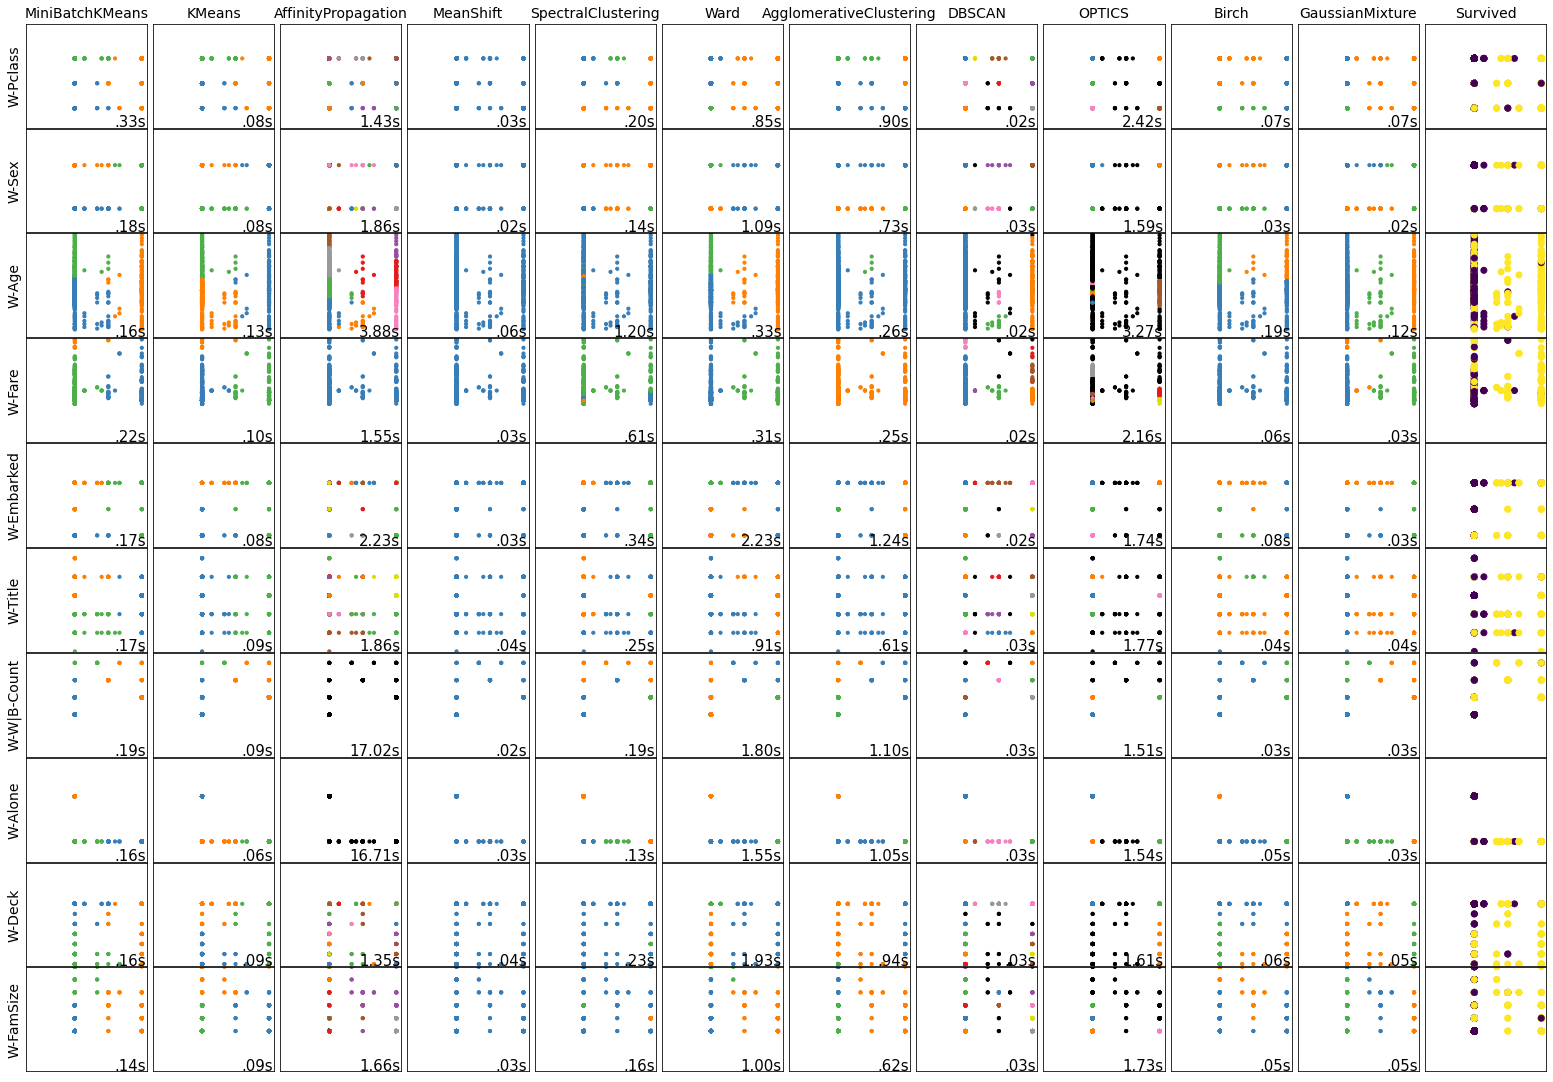

In [26]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(10 * 2 + 2, 15))
plt.subplots_adjust(left=.02, right=.98, bottom=.01, top=.98, wspace=.05,
                    hspace=.01)

plot_num = 1
coord_xy_lim = 2.5
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    datasets_test[i_dataset] = StandardScaler().fit_transform(datasets_test[i_dataset])        

    clustering_algorithms = generate_clustering_algorithms(X,params['n_clusters'])
    clustering_algorithms_test = generate_clustering_algorithms(datasets_test[i_dataset],params['n_clusters'])

    simil = {}
    i = 0

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)       
        
        simil[name] = 1 - cosine(y, y_pred)
        print(i_dataset, i, round(simil[name], 3), title_plot[i_dataset], name)

        if (i == len(clustering_algorithms)-1):
            # determine the optimal clustering method 
            max_simil = max(simil, key=simil.get)
            print('Optimal ==> ', max_simil)
           
            # clustering data by the optimal method - synthesis of a new feature
            if simil[max_simil] > limit_opt:
                train_x_all[title_plot[i_dataset]] = y_pred
                algorithm_opt = dict(clustering_algorithms_test)[max_simil]
                algorithm_opt.fit(datasets_test[i_dataset])
                if hasattr(algorithm_opt, 'labels_'):
                    rez[title_plot[i_dataset]] = algorithm_opt.labels_.astype(np.int)
                else:
                    rez[title_plot[i_dataset]] = algorithm_opt.predict(datasets_test[i_dataset])          

        plt.subplot(len(datasets), len(clustering_algorithms) + 1, plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)
        if name == 'MiniBatchKMeans':
            yt = plt.ylabel(title_plot[i_dataset], size=14,rotation=90)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-coord_xy_lim, coord_xy_lim)
        plt.ylim(-coord_xy_lim, coord_xy_lim)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        i += 1
    # Survived
    plt.subplot(len(datasets), len(clustering_algorithms)+1, plot_num)
    if i_dataset == 0:
        plt.title("Survived", size=14)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(-coord_xy_lim, coord_xy_lim)
    plt.ylim(-coord_xy_lim, coord_xy_lim)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1

plt.show()

In [27]:
rez.head(3)

,W-Sex,W-Fare,W-Title,W-Deck
PassengerId,,,,
892,0,0,1,0
893,2,0,2,0
894,0,0,1,0


### Tuning model

In [28]:
train_x = pd.concat([train_x_all.WomanOrBoySurvived.fillna(0), 
                     train_x_all.Alone, 
                     train_x_all.Sex,
                     ], axis=1)
test_x = pd.concat([test_x_all.WomanOrBoySurvived.fillna(0), 
                     test_x_all.Alone, 
                     test_x_all.Sex,
                     ], axis=1)

In [29]:
rez_col = rez.columns.values.tolist()
rez_col

['W-Sex', 'W-Fare', 'W-Title', 'W-Deck']

In [30]:
train_x = train_x.join(train_x_all[rez_col], how='left', lsuffix="_rez")
train_x.head(2)

,WomanOrBoySurvived,Alone,Sex,W-Sex,W-Fare,W-Title,W-Deck
PassengerId,,,,,,,
1,0.0,1,1,0,0,0,0
2,0.0,1,0,1,0,0,1


In [31]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {'max_depth' : np.arange(2, 9, dtype=int),
              'min_samples_leaf' :  np.arange(1, 4, dtype=int)}
classifier = DecisionTreeClassifier(random_state=1000)
model = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
model.fit(train_x, train_y)
best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 8, 'min_samples_leaf': 1}


In [32]:
model=DecisionTreeClassifier(max_depth = best_parameters['max_depth'], 
                             random_state = 1118)
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=8, random_state=1118)

In [33]:
train_y_pred = model.predict(train_x).astype(int)
diff = sum(abs(train_y-train_y_pred))*100/len(train_y)
diff

6.734006734006734

### Residues of train dataset view

In [34]:
train_x_all['Pred'] = train_y_pred
train_x_all['Survived'] = train_y

In [35]:
pd.set_option('max_columns',100)
pd.set_option('max_rows',100)

In [36]:
train_x_all[train_x_all['Survived'] != train_x_all['Pred']].sort_values(by=['Survived'])

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size,W-Sex,W-Fare,W-Title,W-Deck,Pred,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,,
15,3,0,14.00,0,0,7.8542,2,9,1,821,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
313,2,0,26.00,1,1,26.0000,2,11,1,420,0.0,0.0,0.0,1,7,3,1,0,0,0,1,0.0
397,3,0,31.00,0,0,7.8542,2,9,1,595,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
416,3,0,31.00,0,0,8.0500,2,11,1,515,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
475,3,0,22.00,0,0,9.8375,2,9,1,770,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
502,3,0,21.00,0,0,7.7500,1,9,1,122,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
503,3,0,18.00,0,0,7.6292,1,9,1,590,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
504,3,0,37.00,0,0,9.5875,2,9,1,421,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0
565,3,0,18.00,0,0,8.0500,2,9,1,514,0.0,0.0,0.0,1,7,1,1,0,0,0,1,0.0


In [37]:
diff_nrow = len(train_x_all[train_x_all['Survived'] != train_x_all['Pred']])
diff_nrow

60

### K-Means Algorithm

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

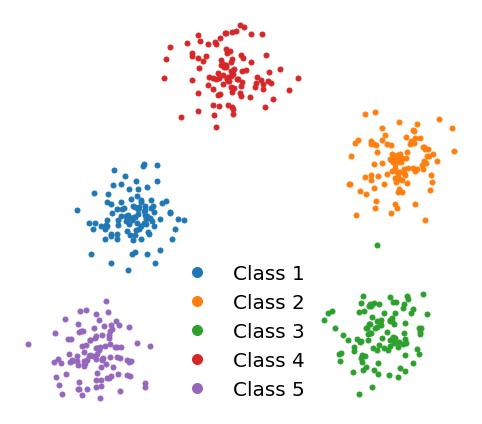

In [39]:
lower, higher = -10, 10
points = 100
clusters = 5
width = 1.2
random_state = 1

np.random.seed(random_state)

data = []
for ix in range(clusters):
    cx, cy = np.random.randint(lower, higher), np.random.randint(lower, higher), 
    x = np.random.normal(cx, width, size=(points,))
    y = np.random.normal(cy, width, size=(points,))
    data.append(
        pd.DataFrame({
            'x': x,
            'y': y,
            'label': ix + 1,
        })
    )
data = pd.concat(data)

X = data.drop('label', axis=1)
y = data.drop(['x', 'y'], axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.set_aspect('equal')
plt.axis('off')
fig.tight_layout()
for group, group_data in data.groupby('label'):
    plt.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group}')
lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)

Next, we need to define a distance function. A very common function is the Euclidean distance. The euclidean distance calculates the square root, however, the squared distance is very similar and computationally a bit easier.

In [40]:
def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2)**2))

# test function
vec1 = np.array([3, 0])
vec2 = np.array([0, 4])

# this is the 3:4:5 triangle and therefore, it should return 5 (Long live Pythagoras)
euclidean_distance(vec1, vec2)

5.0

In [41]:
def squared_difference(dataset, vector, columns=['x', 'y']):
    return ((dataset[columns[0]] - vector[columns[0]])**2 +
                  (dataset[columns[1]] - vector[columns[1]])**2)

As we already know the amount of clusters, lets just set that. For k-means we need a starting point. We will randomly select the number of clusters amount of points from our dataset.

Next we need a function to cluster our dataset according to the center points we have randomly chosen.

In [42]:
number_of_clusters = len(y.label.unique())
centroids = X.sample(number_of_clusters, random_state=random_state)
number_of_clusters

5

In [43]:
def cluster_dataset(dataset, centroids):
    distances = pd.concat([
        ((dataset - centroid)**2).sum(axis=1)
        for ix, centroid in centroids.iterrows()],
        axis=1,
    )
    return dataset.assign( cluster = distances.idxmin(axis=1)), distances.min(axis=1).sum()

In [44]:
clustered, _ = cluster_dataset(X, centroids)

In [45]:
clustered.cluster.unique()

array([2, 3, 1, 0, 4], dtype=int64)

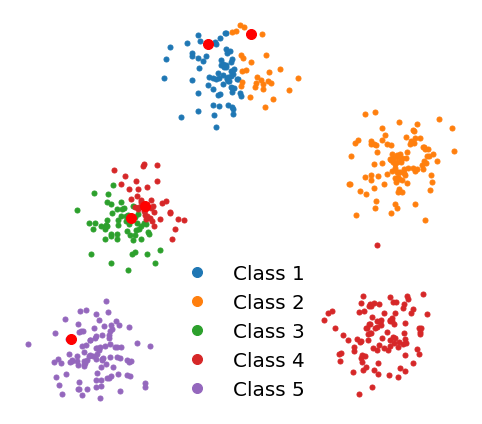

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.set_aspect('equal')
plt.axis('off')
fig.tight_layout()
for group, group_data in clustered.groupby('cluster'):
    plt.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group + 1}')

for ix, centroid in centroids.iterrows():
    ax.plot(centroid.x, centroid.y, 'ro', ms=10)
lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)

The next step in k-means is to update the centroids to have the center averaged over the found cluster. This will move the centroids to the new position and we can repeat this step to converge to the perfect position.

In [47]:
def update_centroids(clustered_dataset):
    new_centroids = clustered_dataset.groupby('cluster').mean().reset_index(drop=True)
    return new_centroids
centroids = update_centroids(clustered)
centroids

,x,y
0,-0.493259,8.678160
1,7.309840,5.134415
2,-5.444337,0.765061
3,4.590739,-2.903448
4,-6.842355,-5.943509


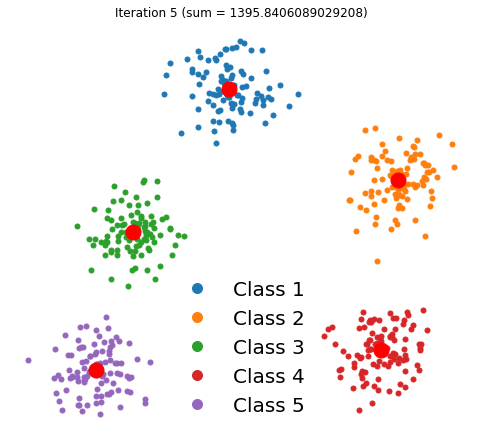

In [48]:
from time import sleep
from IPython.display import clear_output

def plot(clustered, centroids, iteration, total_sum):
    clear_output(wait=True)
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.set_aspect('equal')
    plt.axis('off')
    fig.tight_layout()
    for group, group_data in clustered.groupby('cluster'):
        ax.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group + 1}')
    for ix, centroid in centroids.iterrows():
        ax.plot(centroid.x, centroid.y, 'ro', ms=15)
    lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)
    ax.set_title(f'Iteration {iteration} (sum = {total_sum})')
    plt.show()

    
def cluster_data(dataset, number_of_clusters, max_iter=20, show=False, pause=0.5):
    ds = dataset.copy()
    centroids = ds.sample(number_of_clusters, random_state=random_state)
    previous_sum = pd.Series(range(len(centroids)))
    for iteration in range(max_iter):
        clustered, total_sum = cluster_dataset(ds, centroids)
        centroids = update_centroids(clustered)
        if show:
            plot(clustered, centroids, iteration + 1, total_sum)
            sleep(pause)
        if (total_sum - previous_sum).sum() == 0:  # this is not the best method
            break
        previous_sum = total_sum
    return clustered, centroids, total_sum
            
clust, cent, total_sum = cluster_data(X, number_of_clusters= 5, show=True)

This is a great method to identify groups, however we need to provide the amount of clusters. One way to select this amount is using the Elbow method. This is a visual method in which we plot the average distance of all datapoints to their centroids as function of number of clusters (k). These will go down fast in the beginning and eventually converge to a flat line. This is because we get clusters with only one or a few points and it cannot get much better. The "elbow" of the graph, i.e. the corner is approximately the best k-value. For this, we do need to have the proper distance, i.e. the euclidean distance, as we are summing many distances.

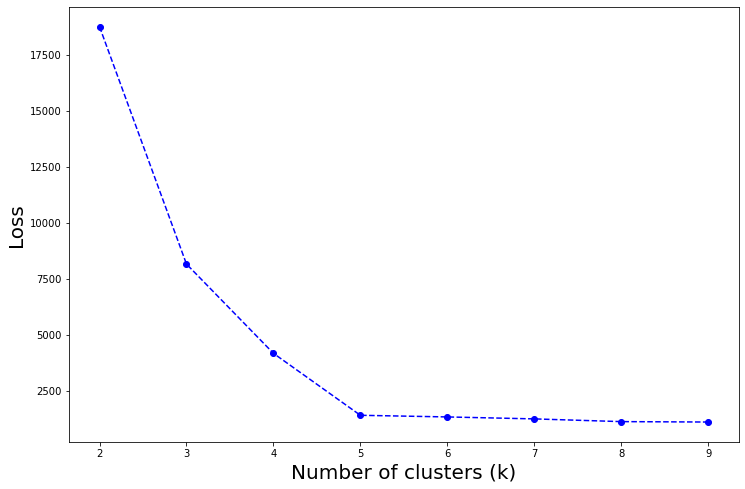

In [49]:
result = {}
for num_of_clust in range(2, 10):
    clust, cent, total_sum = cluster_data(X, number_of_clusters=num_of_clust, show=False)
    result[num_of_clust] = total_sum
    
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(list(result.keys()), list(result.values()), 'bo--')
_ = ax.set_xlabel('Number of clusters (k)', fontsize=20)
_ = ax.set_ylabel('Loss', fontsize=20)

In [50]:
result.values()

dict_values([18765.41979096566, 8155.317646862755, 4165.355556291486, 1395.8406089029208, 1322.012841316648, 1234.5558316259371, 1112.8605589831325, 1094.3048536269732])

The elbow of the graph is around 5, which is exactly the amount of clusters we defined in the beginning. Of course, this is a very nice toy dataset and with real data this might not be so clear. Still, nice to have a confirmation!

### 2. Predict Titanic Survivabillity

In [51]:
combined = pd.read_parquet(r"C:\Users\Dell\Documents\Data Science, Machine Learning\Datasets\titanic_family_survivabillity.parquet")

train = combined.loc[combined['set'] == 'train'].drop('set', axis=1).reset_index(drop=True)
test = combined.loc[combined['set'] == 'test'].drop(['set', 'Survived'], axis=1).reset_index(drop=True)

train['Survived'] = train['Survived'].astype(np.int)

columns = ['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']

In [52]:
clust, cent, total_sum = cluster_data(train[columns], number_of_clusters=100)

clust['Survived'] = train['Survived']
survival_mapper = clust.groupby('cluster')['Survived'].mean().round().astype(np.int).to_dict()
clust['group_survived'] = clust.cluster.map(survival_mapper)
clust

,Pclass,Sex,Fare,family_survival,family_size,cluster,Survived,group_survived
0,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
1,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
2,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
3,-1.546098,0.743497,1.415958,1.498350,0.705051,5,0,0
4,-1.546098,-1.344995,1.415958,1.498350,0.705051,3,1,1
...,...,...,...,...,...,...,...,...
886,0.841916,-1.344995,-1.392358,-0.052117,-0.558346,13,0,1
887,-1.546098,0.743497,1.415958,-0.052117,0.073352,33,0,0
888,-0.352091,0.743497,-0.690279,1.498350,-0.558346,22,0,0
889,-1.546098,-1.344995,1.415958,-1.602583,0.705051,31,1,1


In [53]:
accuracy = (clust['Survived'] == clust['group_survived']).mean()
accuracy  # train dataset accuracy

0.8406285072951739

In [54]:
survival_map = clust.groupby('cluster')['Survived'].mean().round().astype(np.int).to_dict()

predict, loss = cluster_dataset(test[columns], cent)

predict['Survived'] = predict.cluster.map(survival_map)
predict['PassengerId'] = test['PassengerId']
predict = predict[['PassengerId', 'Survived']].sort_values('PassengerId').reset_index(drop=True)
predict

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [55]:
predict.to_csv('results_algorithm_from_scratch.csv', index=False)

### 3. Solution using Scikit-Learn

In [56]:
from sklearn.cluster import KMeans

In [57]:
km = KMeans(
    n_clusters=47,
    init='random',
    n_init=32,
    max_iter=600, 
    tol=1e-5,
    random_state=2020,
)
_ = km.fit(train[['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']])

In [58]:
df = train.copy()
df['cluster'] = km.predict(df[columns])
mapper = df.groupby('cluster')['Survived'].mean().round().to_dict()

df = test.copy()
df['Survived'] = km.predict(test[['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']])
df['Survived'] = df.Survived.map(mapper).astype(np.int)
df = df[['PassengerId', 'Survived']].sort_values('PassengerId').reset_index(drop=True)
df.to_csv('results_scikit_algorithm.csv', index=False)

The Scikit-learn algorithm scores almost the same: 0.796